In [8]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [1]:
import prodimopy.read as pread
import prodimopy.plot as pplot
import prodimopy.plot_models as ppms
from matplotlib.backends.backend_pdf import PdfPages
import pickle
from tqdm import tqdm
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.integrate import simpson
from scipy.constants import h as planck_h
from scipy.constants import k as boltzmann_k
from scipy.constants import c as speed_of_light
from scipy.constants import astronomical_unit as au
from scipy.constants import parsec as pc
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

In [49]:
colors = {'atomic': 'tomato', 'C2H2': 'yellow', 'CH4': 'mediumorchid', 'CO': 'red', 'CO2': 'limegreen', 'H2O': 'dodgerblue',
          'HCN': 'orange', 'NH3': 'cyan', 'NO': 'gold', 'OH': 'magenta'}

In [2]:
with open('ProDiMoData1000_N.pkl', 'rb') as f:
    models = pickle.load(f)

PLOT: plot_cont ...
PLOT: plot_cont ...


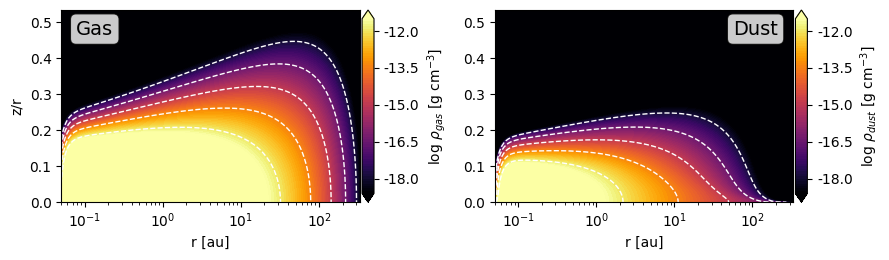

In [3]:
for i,model in enumerate(models):
    if i != 12:
        continue
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)
    # This can be very useful is one wants to have multiple plots with a similar style
    # Here we also change the color map
    constyle = {"cmap": "inferno", "extend": "both", "cb_format": "%.1f", "zlim": [3.e-19, 3.e-12]}

    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0], **constyle)
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1], **constyle)

    # we do not need the z/r axis in the second plot
    axs[1].set_ylabel("")

    # place some text boxes on the plots
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
plt.savefig('Figures/Density.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_cont ...
PLOT: plot_cont ...


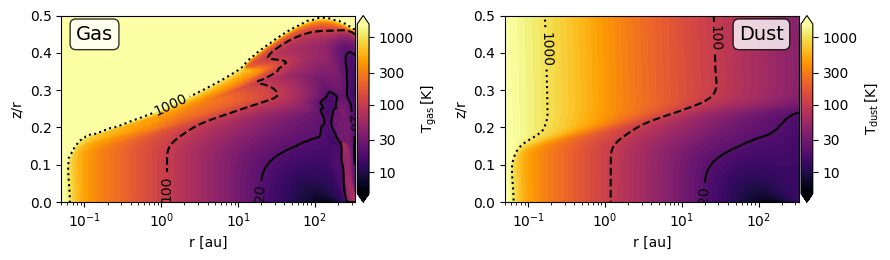

In [4]:
for i,model in enumerate(models):
    if i != 12:
        continue
    fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp=pplot.Plot(None)

    tcont=pplot.Contour(model.tg, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont=pplot.Contour(model.AV,[1.0],colors="black")

    cbticks=[10,30,100,300,1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[0],fig=fig, cmap='inferno')
    tcont=pplot.Contour(model.td, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[1],fig=fig, cmap='inferno')
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
plt.savefig('Figures/Temperature.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...
PLOT: plot_cont ...


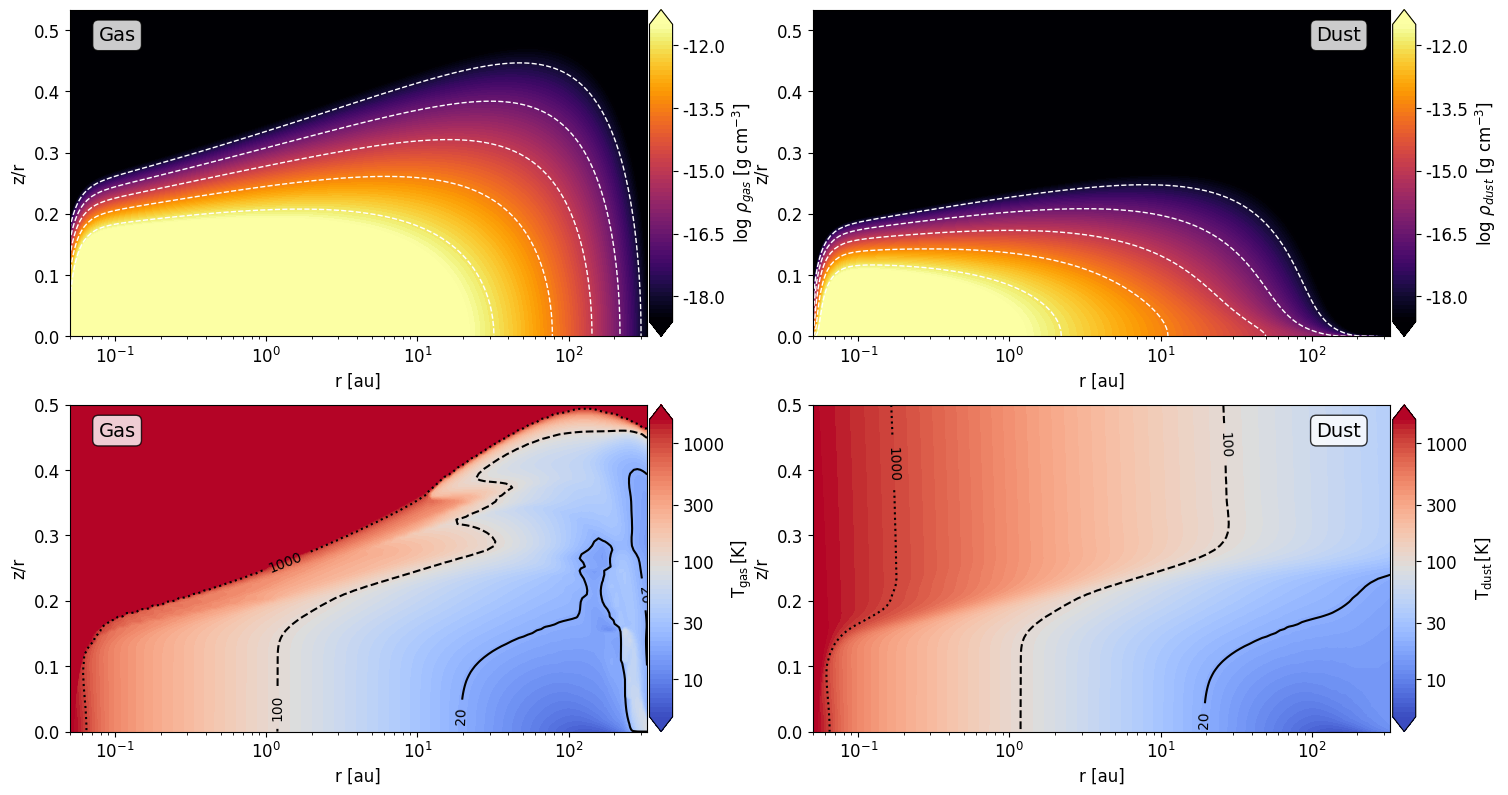

In [46]:
for i,model in enumerate(models):
    if i != 12:
        continue
    # use subplots to plot the gas density and dust density next to each other
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    axs = axs.flatten()
    pp = pplot.Plot(None)
    # This can be very useful is one wants to have multiple plots with a similar style
    # Here we also change the color map
    constyle = {"cmap": "inferno", "extend": "both", "cb_format": "%.1f", "zlim": [3.e-19, 3.e-12]}

    fig = pp.plot_cont(model, model.rhog, label=r"log $\rho_{gas}$ [g cm$^{-3}$]", ax=axs[0], **constyle)
    fig = pp.plot_cont(model, model.rhod, label=r"log $\rho_{dust}$ [g cm$^{-3}$]", ax=axs[1], **constyle)

    # we do not need the z/r axis in the second plot
    # axs[1].set_ylabel("")

    # place some text boxes on the plots
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[0].text(0.05, 0.95, "Gas", transform=axs[0].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[1].text(0.95, 0.95, "Dust", transform=axs[1].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    tcont=pplot.Contour(model.tg, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont=pplot.Contour(model.AV,[1.0],colors="black")

    cbticks=[10,30,100,300,1000]
    _ = pp.plot_cont(model, model.tg, r"$\mathrm{T_{gas}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[2],fig=fig, cmap='coolwarm')
    tcont=pplot.Contour(model.td, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f", colors='black')
    _ = pp.plot_cont(model, model.td, r"$\mathrm{T_{dust}\,[K]}$",zr=True,xlog=True,
                    ylim=[0,0.5], zlim=[5,1500],extend="both",
                    oconts=[tcont],   # here the addtional contour added
                    contour=False,           # switch of the standard contours
                    clevels=cbticks,         # explictly set ticks for the cbar
                    clabels=map(str,cbticks),# and make some nice labels
                    cb_format="%.0f",
                    ax=axs[3],fig=fig, cmap='coolwarm')
    props = dict(boxstyle='round', facecolor='white', alpha=0.8)
    axs[2].text(0.05, 0.95, "Gas", transform=axs[2].transAxes, fontsize=14,
                verticalalignment='top', bbox=props)

    ret = axs[3].text(0.95, 0.95, "Dust", transform=axs[3].transAxes, fontsize=14,
                      verticalalignment='top', horizontalalignment="right", bbox=props)
    plt.tight_layout()
fig = plt.gcf()
for ax in fig.get_axes():
    ax.set_xlabel(ax.get_xlabel(), fontsize=12)
    ax.set_ylabel(ax.get_ylabel(), fontsize=12)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    if ax.get_label() == '<colorbar>':
        ax.tick_params(labelsize=20)  # Tick label size
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)  # Label size
plt.savefig('Figures/DensityTemperature.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont_grid ...
[1e-15, 0.001]


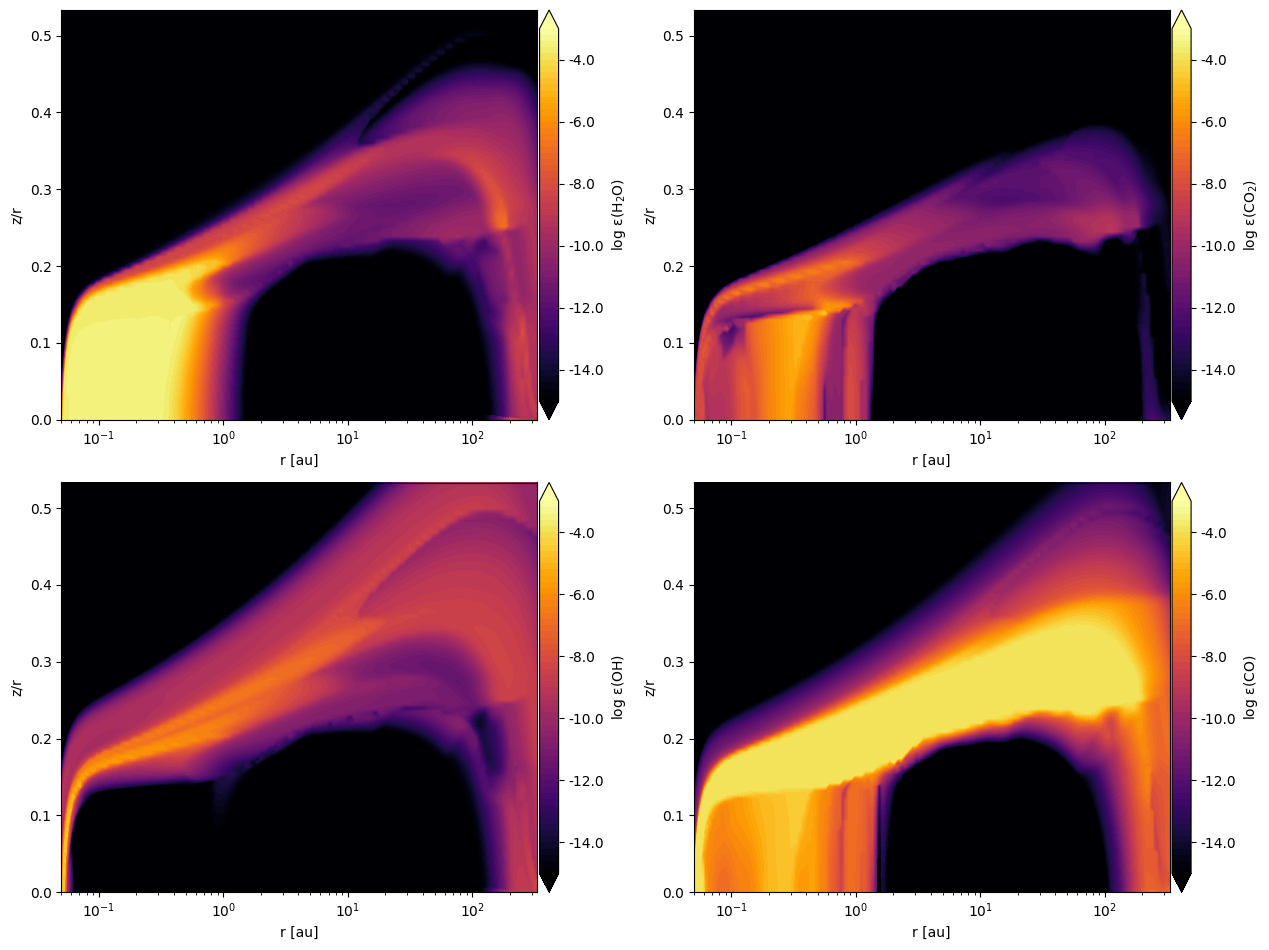

In [30]:
for i,model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp=pplot.Plot(None)

    tcont=pplot.Contour(model.tg, [20,100,1000], linestyles=["-","--",":"],
                      showlabels=True,label_fontsize=10,label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont=pplot.Contour(model.AV,[1.0],colors="black")

    cbticks=[10,30,100,300,1000]
    _ =pp.plot_abuncont_grid(model,
                          ["H2O","CO2" ,"OH","CO"],nrows=2, ncols=2,
                          zlim=[1.e-15,1.e-3],extend="both",contour=False, cmap='inferno')
    plt.tight_layout()
    # _ =pp.plot_abuncont_grid(model,
    #                       ["HCN#","NH3#","NO#","H2O#"],nrows=2, ncols=2,
    #                       zlim=[1.e-8,1.e-3],extend="both",contour=False, cmap='inferno')
plt.savefig('Figures/Abundance1.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont ...


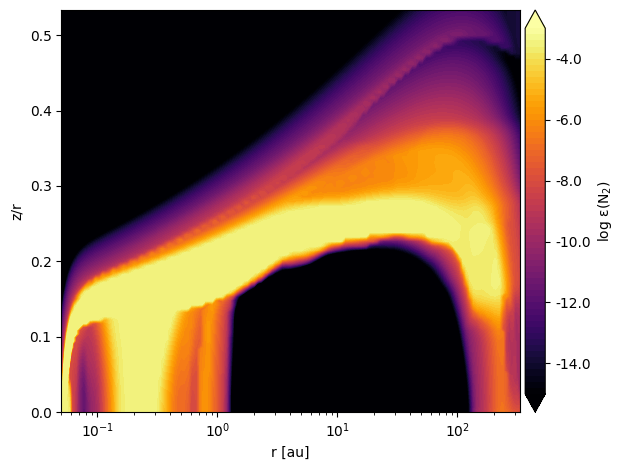

In [34]:
for i, model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)

    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    # _ = pp.plot_abuncont_grid(model,
    #                           ["HCN", "HNC", "NH3", "NO"], nrows=2, ncols=2,
    #                           zlim=[1.e-15, 1.e-3], extend="both", contour=False, cmap='inferno')
    fig=pp.plot_abuncont(model,"N2",zlim=[1.e-15, 1.e-3],extend="both",contour=False, cmap='inferno')
    plt.tight_layout()
    # _ =pp.plot_abuncont_grid(model,
    #                       ["HCN#","NH3#","NO#","H2O#"],nrows=2, ncols=2,
    #                       zlim=[1.e-8,1.e-3],extend="both",contour=False, cmap='inferno')
plt.savefig('Figures/AbundanceN2.pdf', bbox_inches='tight')
plt.show()

PLOT: plot_abuncont_grid ...
[1e-15, 0.001]


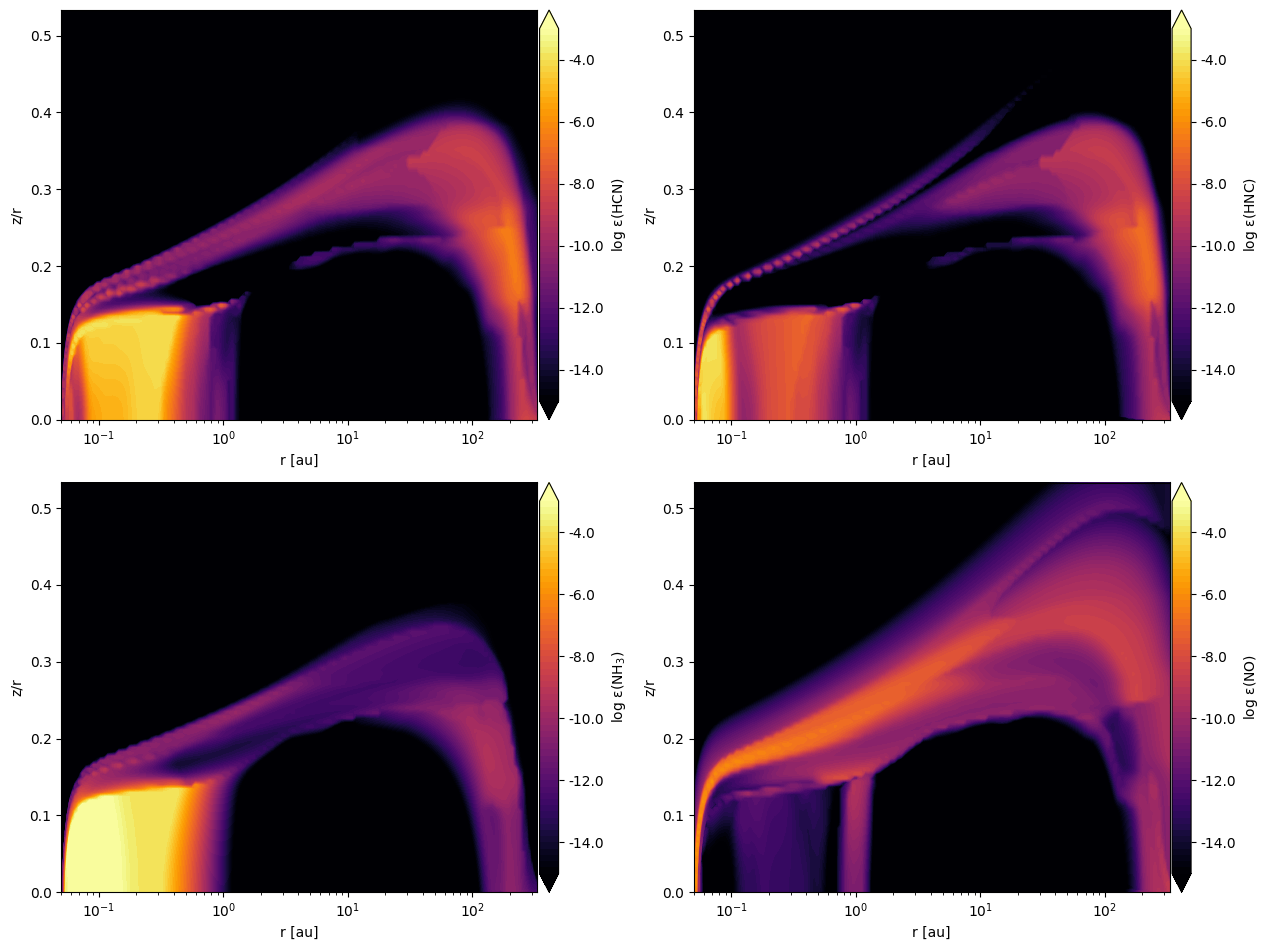

In [36]:
plt.show()
for i, model in enumerate(models):
    if i != 12:
        continue
    # fig, axs = plt.subplots(1, 2, figsize=(9, 2.7))
    pp = pplot.Plot(None)

    tcont = pplot.Contour(model.tg, [20, 100, 1000], linestyles=["-", "--", ":"],
                          showlabels=True, label_fontsize=10, label_fmt="%.0f")
    #tcont.label_locations=[(100,100),(55,5),(40,5)]

    # another contour, a simple one
    avcont = pplot.Contour(model.AV, [1.0], colors="black")

    cbticks = [10, 30, 100, 300, 1000]
    _ = pp.plot_abuncont_grid(model,
                              ["HCN", "HNC", "NH3", "NO"], nrows=2, ncols=2,
                              zlim=[1.e-15, 1.e-3], extend="both", contour=False, cmap='inferno', fontsize=14)
    plt.tight_layout()
    # _ =pp.plot_abuncont_grid(model,
    #                       ["HCN#","NH3#","NO#","H2O#"],nrows=2, ncols=2,
    #                       zlim=[1.e-8,1.e-3],extend="both",contour=False, cmap='inferno')
plt.savefig('Figures/Abundance2.pdf', bbox_inches='tight')
plt.show()

In [6]:
with open('FLiTsData1000_N.pkl', 'rb') as f:
    df = pickle.load(f)

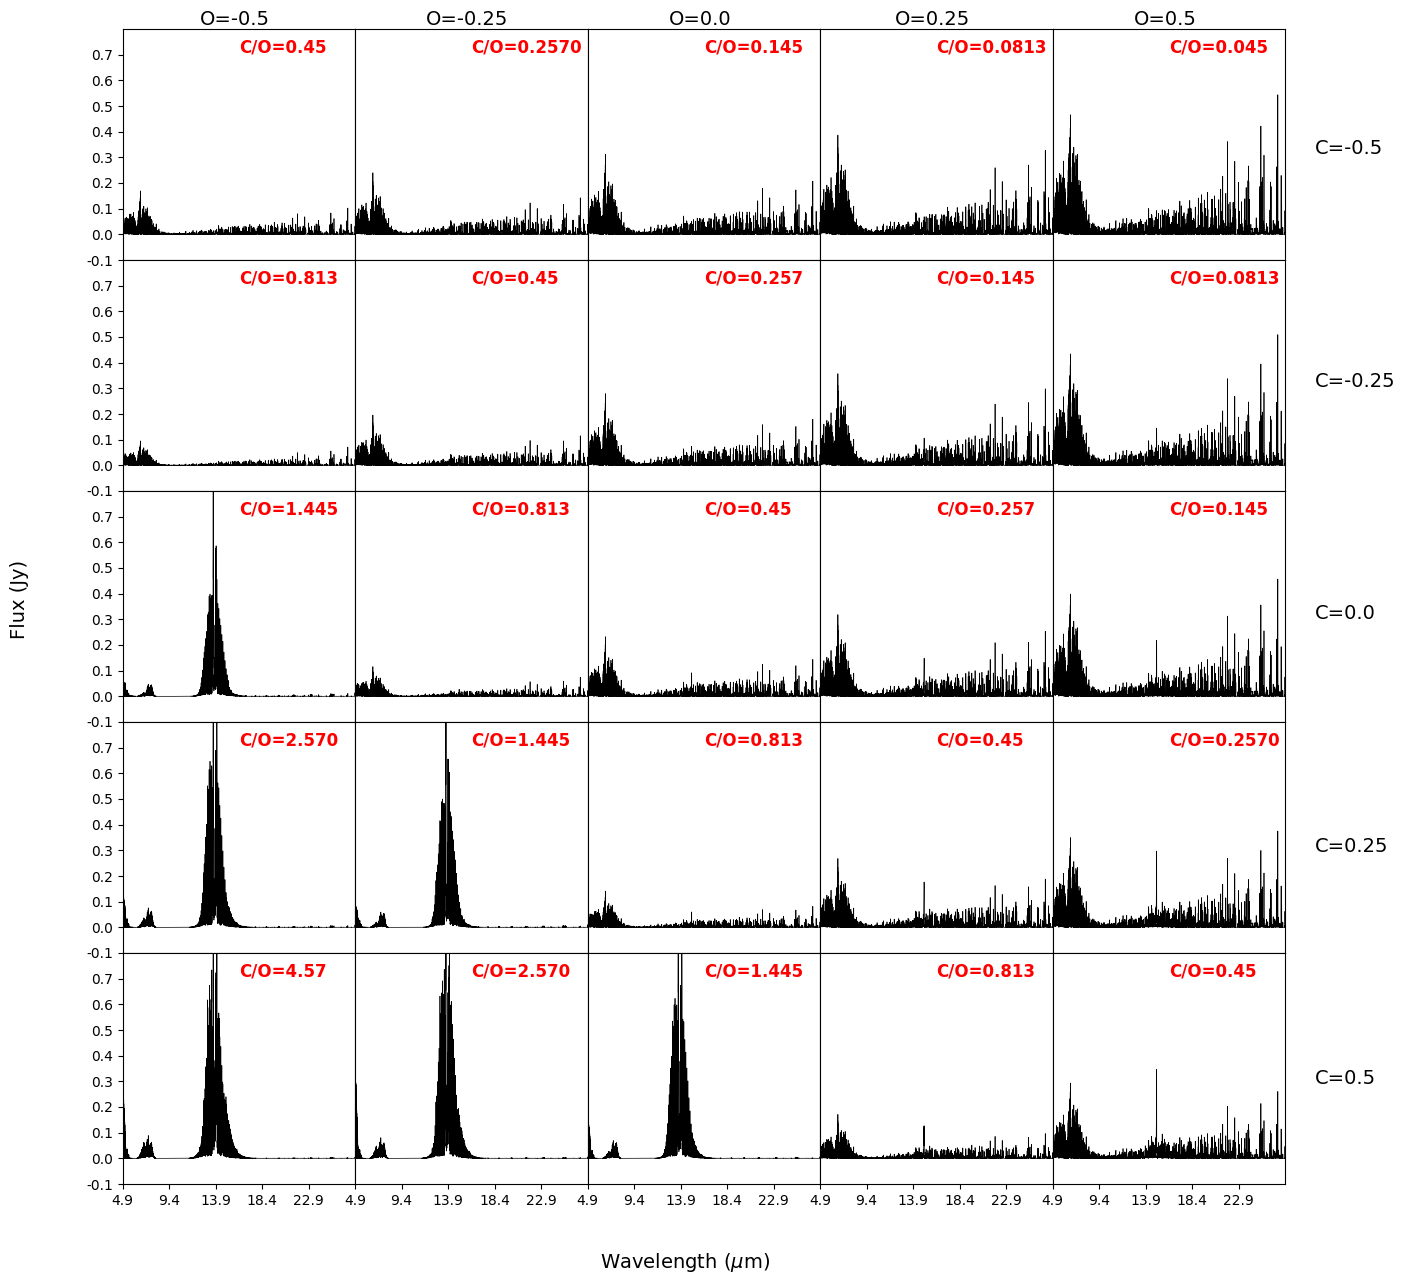

In [18]:
# %matplotlib notebook
plt.close('all')
total_spec = None
cmap = mpl.colormaps.get_cmap('tab20')
# fig, ax = plt.subplots(figsize=(14, 5))
species = ['C2H2','CH4', 'CO', 'CO2', 'H2O', 'HCN',  'NO', 'O2', 'OH','NH3']
# species = ['atomic', 'CH4',  'CO', 'CO2', 'HCN', 'NH3', 'NO', 'O2', 'OH']
species =['NH3']
fig = plt.figure(figsize=(15, 15))
gs = fig.add_gridspec(5, 5, hspace=0, wspace=0)
axes = gs.subplots(sharex='col', sharey='row').flatten()
xrange=[4.9, 27.4]
yrange=[-0.1,0.8]
num_xticks = 6
num_yticks = 10
for i in range(25):
    n_row, n_col = divmod(i, 5)
    total_spec = None
    # fig, ax = plt.subplots(figsize=(14, 5))
    model = df['Model Name'][i]
    FLiTs_wl = df.loc[df['Model Name'] == model, 'FLiTs Wavelength'].values[0].copy()
    FLiTs_flux = df.loc[df['Model Name'] == model, 'FLiTs Flux'].values[0].copy()
    # for index, specie in enumerate(species):
    #     specie_wl = df.loc[df['Model Name'] == model, f'FLiTs {specie} Wavelength'].values[0].copy()
    #     specie_flux = df.loc[df['Model Name'] == model, f'FLiTs {specie} Flux'].values[0].copy()
    #     new_specie_flux = np.interp(FLiTs_wl, specie_wl, specie_flux, left=0, right=0)
    #     if total_spec is None:
    #         total_spec = new_specie_flux
    #     else:
    #         total_spec += new_specie_flux
    #     axes[i].fill_between(FLiTs_wl, 0, total_spec*1000, label=specie, zorder=len(species) - index+1,
    #                     color=cmap(index / len(species)))
        # ax.fill_between(specie_wl,0, specie_flux*1000, label=specie, zorder=len(species) - index+1,
        #                 color=cmap(index / len(species)))
        # new_flux = np.interp(FLiTs_wl, specie_wl, specie_flux)
        # ax.plot(FLiTs_wl, np.log10(new_flux/FLiTs_flux+1))
        # axes[i].plot(FLiTs_wl, new_specie_flux*1000)
    axes[i].plot(FLiTs_wl, FLiTs_flux, c='black', lw=.5, label='FLiTs', zorder=20, rasterized=True)
    # ax.plot(specie_wl, specie_flux)
    # ax.plot(total_FLiTs_wl, interp_flux*1000, color='grey', zorder=30)
    # fig.suptitle(model)
    axes[i].text(xrange[0] + (xrange[1] - xrange[0]) * 0.5, yrange[0] + (yrange[1] - yrange[0]) * 0.9,f'C/O={df.loc[df['Model Name'] == model, 'CO Value'].values[0]}', fontsize=12, color='red',weight='bold')
    axes[i].set_xlim(xrange)
    axes[i].set_ylim(yrange)
    if n_col == 0:
        # axes[i].set_ylabel("Flux (Jy)", fontsize=14)
        axes[i].set_yticks(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
        axes[i].set_yticklabels(np.linspace(yrange[0] * 100, yrange[1] * 100, num_yticks, dtype=int)[:-1] / 100)
    else:
        axes[i].tick_params(labelleft=False, left=False)
    if n_row == 4:
        # axes[i].set_xlabel(r"Wavelength ($\mu$m)", fontsize=14)
        axes[i].set_xticks(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
        axes[i].set_xticklabels(np.linspace(xrange[0] * 100, xrange[1] * 100, num_xticks, dtype=int)[:-1] / 100)
    else:
        axes[i].tick_params(labelbottom=False, bottom=False)
# Convert to 2D array for easier indexing
axes_grid = axes.reshape(5, 5)

# Label top (columns)
for i in range(5):
    fig.text(0.2 + i * 0.155, 0.88, f'O={.25*i-0.5}', ha='center', va='bottom', fontsize=14)

# Add right row labels
for i in range(5):
    fig.text(0.92, 0.8 - i * 0.155, f'C={.25*i-0.5}', va='center', ha='left', fontsize=14)
fig.supxlabel(r'Wavelength ($\mu$m)', fontsize=14, y=0.05)
fig.supylabel('Flux (Jy)', fontsize=14, x=0.05)
plt.savefig('Figures/All_spectra.pdf', bbox_inches='tight')
plt.show()

In [19]:
data = []
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)

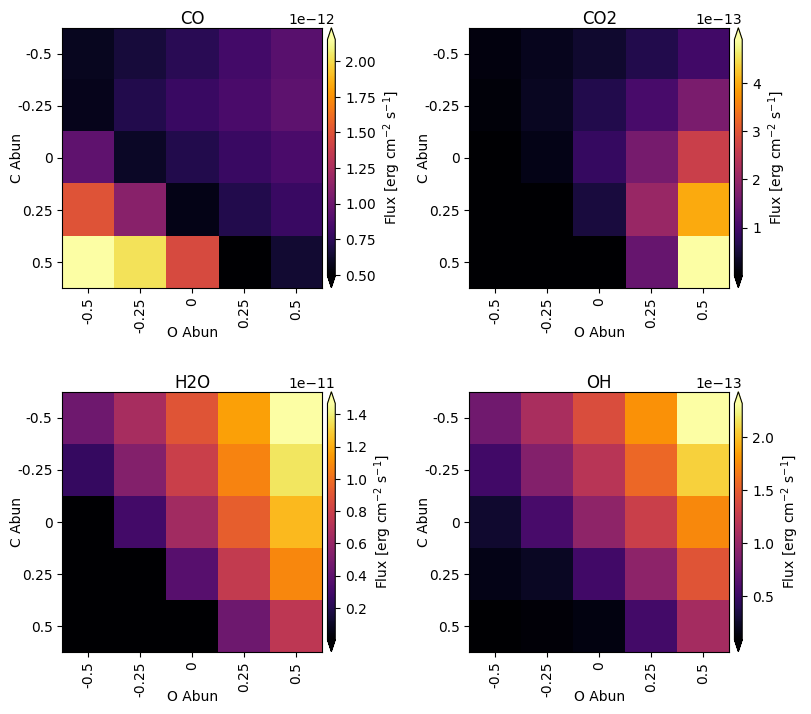

In [47]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
# ['HCN', 'NH3', 'NO']
# ['CO', 'CO2', 'H2O', 'OH']
# Flatten the axes array for easy iteration
for i, specie in enumerate(['CO', 'CO2', 'H2O', 'OH']):
    im = axes[i].imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='inferno')
    axes[i].set_title(specie, pad=-5)
    axes[i].set_xticks(np.arange(5))
    axes[i].set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    axes[i].set_yticks(np.arange(5))
    axes[i].set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5])
    axes[i].set_xlabel('O Abun', labelpad=-5)
    axes[i].set_ylabel('C Abun', labelpad=-5)
    cax = inset_axes(axes[i],
                     width="3%",      # width of the colorbar
                     height="100%",   # full height of the plot
                     loc='right',
                     bbox_to_anchor=(0.05, 0., 1, 1),
                     bbox_transform=axes[i].transAxes,
                     borderpad=0)
    fig.colorbar(im, cax=cax, label='Flux [erg cm$^{-2}$ s$^{-1}$]', extend='both')
# plt.tight_layout()
# axes[3].remove()
fig.subplots_adjust(top=0.9, bottom=0.12, left=0.1, right=0.82, hspace=0.4, wspace=0.3)  # give more space top and bottom
plt.savefig('Figures/Heatmaps1.pdf', bbox_inches='tight')
plt.show()

# [erg cm$^{-2}$ s$^{-1}$]

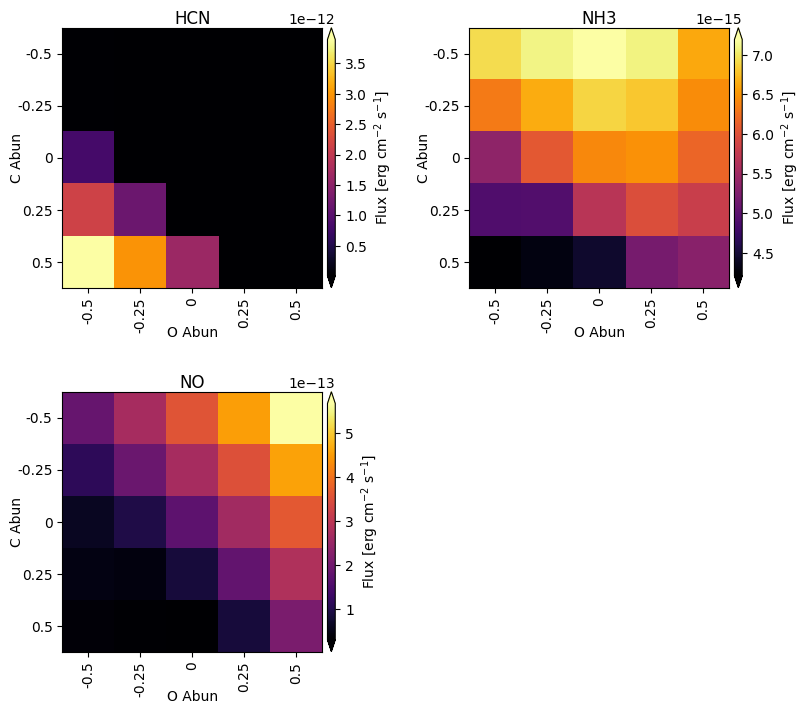

In [21]:
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()
# ['HCN', 'NH3', 'NO']
# ['CO', 'CO2', 'H2O', 'OH']
# Flatten the axes array for easy iteration
for i, specie in enumerate(['HCN', 'NH3', 'NO']):
    im = axes[i].imshow(df_FLiTs_flux[specie].values.reshape(5,5), cmap='inferno')
    axes[i].set_title(specie, pad=-5)
    axes[i].set_xticks(np.arange(5))
    axes[i].set_xticklabels([-0.5, -0.25, 0, 0.25, 0.5], rotation=90)
    axes[i].set_yticks(np.arange(5))
    axes[i].set_yticklabels([-0.5, -0.25, 0, 0.25, 0.5])
    axes[i].set_xlabel('O Abun', labelpad=-5)
    axes[i].set_ylabel('C Abun', labelpad=-5)
    cax = inset_axes(axes[i],
                     width="3%",      # width of the colorbar
                     height="100%",   # full height of the plot
                     loc='right',
                     bbox_to_anchor=(0.05, 0., 1, 1),
                     bbox_transform=axes[i].transAxes,
                     borderpad=0)
    fig.colorbar(im, cax=cax, label='Flux [erg cm$^{-2}$ s$^{-1}$]', extend='both')
# plt.tight_layout()
axes[3].remove()
fig.subplots_adjust(top=0.9, bottom=0.12, left=0.1, right=0.82, hspace=0.4, wspace=0.3)  # give more space top and bottom
plt.savefig('Figures/Heatmaps2.pdf', bbox_inches='tight')
plt.show()

# [erg cm$^{-2}$ s$^{-1}$]

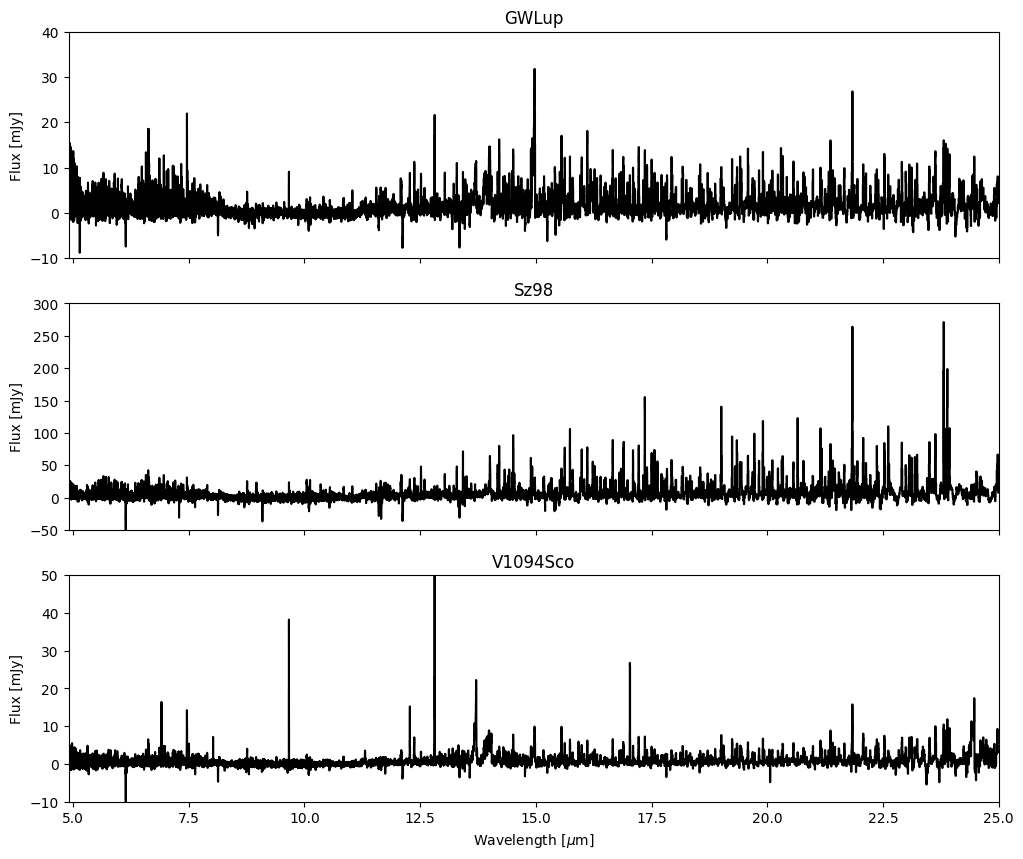

In [63]:
ylims = [(-10, 40), (-50, 300), (-10, 50)]
fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux_cont_sub = data['CSFlux']

    clip_min, clip_max = 4.9, 25

    mask = np.ones_like(wavelength, dtype=bool)
    for start, end in artefact_regions:
        mask &= ~((wavelength >= start) & (wavelength <= end))

    clip_cnd = (wavelength >= clip_min) & (wavelength <= clip_max)
    axs[i].step(wavelength[clip_cnd], flux_cont_sub[clip_cnd]*1000, color='black')
    axs[i].set_ylabel('Flux [mJy]')
    axs[i].set_xlim(clip_min, clip_max)
    axs[i].set_title(Source)
    axs[i].set_ylim(ylims[i])
axs[-1].set_xlabel(r'Wavelength [$\mu$m]')
fig.savefig(f'Figures/Measurements.pdf', bbox_inches='tight')
plt.show()

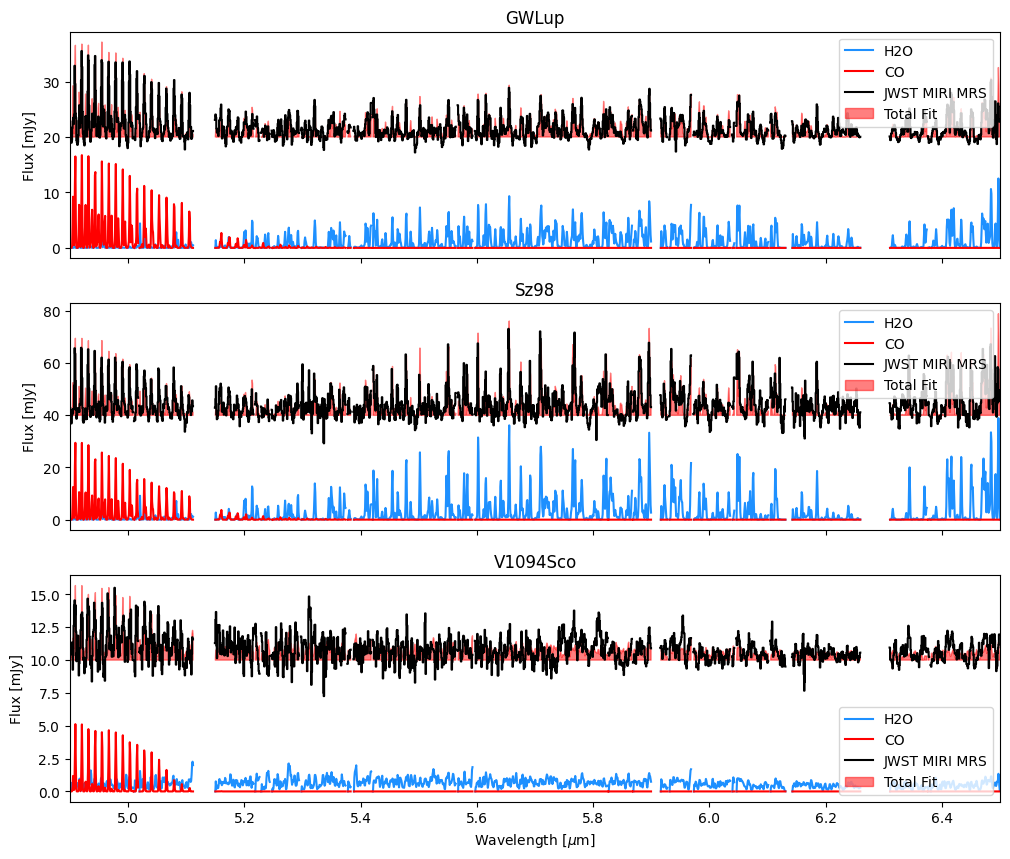

In [56]:
plt.show()
import math
from scipy.ndimage import gaussian_filter1d


def mask_regions(wavelength, flux, regions):
    new_flux = flux.copy()
    for region in regions:
        new_flux[np.logical_and(wavelength > region[0], wavelength < region[1])] = np.nan
    return new_flux


artefact_regions = [[5.0091, 5.01071], [5.018, 5.019], [5.112, 5.15],
                    [5.2157, 5.2184], [5.2267, 5.2290], [5.2441, 5.2471],
                    [5.2947, 5.2974], [5.3742, 5.3777], [5.3836, 5.3877],
                    [5.4181, 5.4210], [5.5644, 5.5674], [5.5925, 5.5966],
                    [5.8252, 5.8267], [5.8669, 5.8689], [5.9, 5.916], [5.9282, 5.9314],
                    [5.9691, 5.9728], [6.0357, 6.0394], [6.0430, 6.0462],
                    [6.1012, 6.1044], [6.1311, 6.1421], [6.26, 6.31], [6.3740, 6.3757],
                    [6.3783, 6.3810], [18.8055, 18.8145], [19.004, 19.012],
                    [21.974, 21.985], [25.69824, 25.71313]]
fig, axs = plt.subplots(3,1, figsize=(12, 10), sharex=True)
for i, Source in enumerate(['GWLup', 'Sz98', 'V1094Sco']):

    # Load main spectrum data
    file = f'FullSpectrum_CS_{Source}.p'
    data = pickle.load(open(file, 'rb'))
    wavelength = data['Wavelength']
    flux_cont_sub = data['CSFlux']

    clip_min, clip_max = 4.9, 6.5  # micron

    # Mask artefact regions
    mask = np.ones_like(wavelength, dtype=bool)
    for start, end in artefact_regions:
        mask &= ~((wavelength >= start) & (wavelength <= end))

    clip_cnd = (wavelength >= clip_min) & (wavelength <= clip_max)
    total = np.zeros_like(flux_cont_sub[clip_cnd])

    for mol in ['H2O', 'CO']:
        file = f'{Source}4_9_6_3/{mol}_best_fit.p'
        data = pickle.load(open(file, 'rb'))
        o_w = data['o_w']
        m_f = np.nan_to_num(data['m_f'], nan=0)
        rdisk_sq = data['Rdisk_best'] ** 2
        axs[i].plot(o_w, mask_regions(o_w, 1000 * m_f * rdisk_sq, artefact_regions), c=colors[mol], label=mol)
        total += m_f * rdisk_sq

    # Add offset JWST spectrum and total fit
    offset = math.ceil(max(1000 * flux_cont_sub[clip_cnd]) / 10) * 10
    masked_flux = 1000 * mask_regions(wavelength[clip_cnd], flux_cont_sub[clip_cnd], artefact_regions) + offset
    axs[i].step(wavelength[clip_cnd], masked_flux, color='black', label='JWST MIRI MRS')

    masked_total = 1000 * mask_regions(wavelength[clip_cnd], total, artefact_regions) + offset
    axs[i].fill_between(wavelength[clip_cnd], offset, masked_total, color='r', alpha=0.5, label='Total Fit')

    # Labeling and styling
    # axs[i].set_xlabel(r'Wavelength [$\mu$m]')
    axs[i].set_ylabel('Flux [mJy]')
    axs[i].set_xlim(clip_min, clip_max)
    axs[i].set_title(Source)
    axs[i].legend()
axs[-1].set_xlabel(r'Wavelength [$\mu$m]')
# Save and show
fig.savefig(f'Figures/Fits.pdf', bbox_inches='tight')
plt.show()